# SageMaker Payment Classification 


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

---


## Background <a class="anchor" id="Background"></a>

This notebook demonstrates how you can train and deploy a machine learning model to classify payment transactions. Enriching financial transactions with the category of the transaction. This can be used as an intermediate step in fraud detection, personalization or anomaly detection. As well as a method to provide end users (e.g. customers at a bank) with an overview of their spending habits. Amazon SageMaker can be used to train and deploy a XGBoost model, as well as the required underlying infrastructure. For this notebook a generated dataset is used where a payment consists of mostly an amount, sender, receiver and timestamp.


## Notebook overview <a class="anchor" id="Notebook-overview"></a>

This notebook consists of seven parts. First, we import and configure the required libraries. After that we prepare the data used in this example and create the feature store. With the newly created features we create a XGBoost model. An endpoint is created to host this model. We evaluate the performance of the model and end by cleaning up the used resources.

## Dataset <a class="anchor" id="Dataset"></a>

For this notebook we use a synthetic dataset. This dataset has the following features 

* __transaction_category__: The category of the transaction, this is one of the next 19 options.

               'Uncategorized', 'Entertainment', 'Education',
                    'Shopping', 'Personal Care', 'Health and Fitness',
             'Food and Dining', 'Gifts and Donations', 'Investments',
         'Bills and Utilities', 'Auto and Transport', 'Travel',
            'Fees and Charges', 'Business Services', 'Personal Services',
                       'Taxes', 'Gambling', 'Home',
      'Pension and insurances'


* __receiver_id__: an identifier for the receiving party. The identifier consist of 16 numbers.
* __sender_id__: an identifier for the sending party. The identifier consist of 16 numbers.
* __amount__: the amount which is transferred.
* __timestamp__: the timestamp of the transaction in YYYY-MM-DD HH:MM:SS format.


### 1. Setup <a class="anchor" id="Setup"></a>

Before we start we need to update the sagemaker library

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip       --quiet # upgrade pip to the latest vesion
# !{sys.executable} -m pip install --upgrade sagemaker --quiet # upgrade SageMaker to the latest vesion
# !{sys.executable} -m pip install --upgrade boto      --quiet # upgrade boto to the latest vesion

In [2]:
import mlrun

In [3]:
project = mlrun.get_or_create_project(
    name="sagemaker-v3", 
    user_project=True,
    parameters={
        # "source" : "git://github.com/mlrun/demo-sagemaker#main",
        "default_image" : "yonishelach/sagemaker-demo"
    }
)

> 2024-02-07 16:34:18,167 [info] Project loaded successfully: {'project_name': 'sagemaker-v3'}


Now that we have the latest version we can import the libraries that we'll use in this notebook

In [4]:
import boto3
import io
import sagemaker
import time
import os
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
sagemaker_role = os.environ["SAGEMAKER-ROLE"]

In [6]:
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "sagemaker-app-lab"

Let's set the session variables to ensure that SageMaker is configured correctly.

In [7]:
region = sagemaker.Session().boto_region_name
sm_client = boto3.client("sagemaker")
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.session.Session(boto_session=boto_session, sagemaker_client=sm_client)
role = sagemaker_role
bucket_prefix = "payment-classification"
s3_bucket = sagemaker_session.default_bucket()

We define the factorize key which is used to map the '__transaction_category__' to numeric values

In [8]:
factorize_key = {
    "Uncategorized": 0,
    "Entertainment": 1,
    "Education": 2,
    "Shopping": 3,
    "Personal Care": 4,
    "Health and Fitness": 5,
    "Food and Dining": 6,
    "Gifts and Donations": 7,
    "Investments": 8,
    "Bills and Utilities": 9,
    "Auto and Transport": 10,
    "Travel": 11,
    "Fees and Charges": 12,
    "Business Services": 13,
    "Personal Services": 14,
    "Taxes": 15,
    "Gambling": 16,
    "Home": 17,
    "Pension and insurances": 18,
}

### 2. Data preparation <a class="anchor" id="Data-preparation"></a>

We ingest the simulated data from the public SageMaker S3 training database:

In [9]:
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{region}",
    "datasets/tabular/synthetic_financial/financial_transactions_mini.csv",
    "financial_transactions_mini.csv",
)

Let's start by loading the dataset from our csv file into a Pandas dataframe

In [10]:
data = pd.read_csv(
    "financial_transactions_mini.csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
    dtype={"transaction_category": "string"},
)

The dataframe looks as follows:

| | transaction_category | receiver_id | sender_id | amount | timestamp |
|------:|:-----------------------|-----------------:|-----------------:|---------:|:--------------------|
| 39733 | Shopping | 4258863736072564 | 4630246970548037 | 91.58 | 2021-03-10 01:28:23 |
| 27254 | Shopping | 4356269497886716 | 4752313573239323 | 115.17 | 2021-01-22 23:28:24 |
| 30628 | Shopping | 4233636409552058 | 4635766441812956 | 90.98 | 2021-02-05 03:24:10 |
| 46614 | Shopping | 4054967431278644 | 4823810986511227 | 86.74 | 2021-04-02 14:42:45 |
| 37957 | Shopping | 4831814582525664 | 4254514582909482 | 123.27 | 2021-03-17 11:17:18 |
| 46878 | Shopping | 4425943481448900 | 4349267977109013 | 65.53 | 2021-03-17 15:47:49 |
| 81350 | Auto and Transport | 4146116413442105 | 4062723166078919 | 91.67 | 2021-03-29 13:23:44 |
| 10613 | Entertainment | 4788727923958282 | 4485838385631386 | 76.22 | 2021-02-11 17:45:53 |
| 46715 | Shopping | 4702782703461430 | 4944181591271506 | 86.67 | 2021-03-20 15:37:17 |
| 69110 | Investments | 4180233446952120 | 4702069426390603 | 530.39 | 2021-04-21 08:28:13 |

Next, we extract the year, month, day, hour, minute, second from the timestamp and remove the timestamp

In [11]:
for key, val in factorize_key.items():
    factorize_key[key] = str(val)

In [12]:
data["transaction_category_key"] = data["transaction_category"].replace(factorize_key)

In [13]:
data['transaction_id']= data.reset_index().index 

In [14]:
# Function that updates the timestamps so each transaction category has rows with timestamps from the last 5 days (2 per day)
from utils import update_timestamps
data = update_timestamps(data)
data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,transaction_category,receiver_id,sender_id,amount,timestamp,transaction_category_key,transaction_id
106,Uncategorized,4.601853e+15,4.274416e+15,879.39,2021-01-01 15:07:52,0,106.0
378,Uncategorized,4.274544e+15,4.366884e+15,628.01,2021-01-01 16:33:53,0,378.0
368,Uncategorized,4.601853e+15,4.161674e+15,89.69,2021-01-01 18:17:29,0,368.0
17,Uncategorized,4.518552e+15,4.619387e+15,222.01,2021-01-01 18:33:18,0,17.0
178,Uncategorized,4.274544e+15,4.456440e+15,418.52,2021-01-01 19:33:31,0,178.0
...,...,...,...,...,...,...,...
69938,Bills and Utilities,4.904096e+15,4.133603e+15,124.08,2024-02-05 15:00:00,9,69938.0
70592,Bills and Utilities,4.904096e+15,4.444087e+15,188.66,2024-02-06 10:00:00,9,70592.0
70379,Bills and Utilities,4.200241e+15,4.202495e+15,139.27,2024-02-06 15:00:00,9,70379.0
70462,Bills and Utilities,4.612985e+15,4.525455e+15,12.49,2024-02-07 10:00:00,9,70462.0


In [15]:
main_categories = list(factorize_key.keys())
part_categories = main_categories[:3] 
part_data = data[data['transaction_category'].isin(part_categories)][:9999]
part_data

,transaction_category,receiver_id,sender_id,amount,timestamp,transaction_category_key,transaction_id
106,Uncategorized,4.601853e+15,4.274416e+15,879.39,2021-01-01 15:07:52,0,106.0
378,Uncategorized,4.274544e+15,4.366884e+15,628.01,2021-01-01 16:33:53,0,378.0
368,Uncategorized,4.601853e+15,4.161674e+15,89.69,2021-01-01 18:17:29,0,368.0
17,Uncategorized,4.518552e+15,4.619387e+15,222.01,2021-01-01 18:33:18,0,17.0
178,Uncategorized,4.274544e+15,4.456440e+15,418.52,2021-01-01 19:33:31,0,178.0
...,...,...,...,...,...,...,...
7192,Entertainment,4.957788e+15,4.353876e+15,45.85,2021-03-20 19:45:04,1,7192.0
2935,Entertainment,4.116469e+15,4.801157e+15,57.44,2021-03-20 19:50:49,1,2935.0
500,Entertainment,4.952788e+15,4.081148e+15,12.37,2021-03-20 19:52:54,1,500.0
1605,Entertainment,4.328906e+15,4.795968e+15,66.62,2021-03-20 19:53:24,1,1605.0


### 3. Create feature store <a class="anchor" id="Create-feature-store"></a>

To enrich dataset we will use the [Feature Store](https://aws.amazon.com/sagemaker/feature-store/). 

#### feature-group-payment-classification

In [16]:
def calculate_category_distance(event):
    category = event['transaction_category']
    #event[category+'distance'] = abs(event['amount']-event[category+'_avg_1d'])
    event['distance'] = abs(event['amount']/2)
    return event

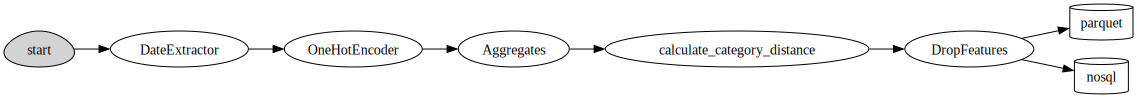

In [17]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor, DropFeatures

# Define and add value mapping
main_categories = list(factorize_key.keys())

main_categories = part_categories

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories}

# creating feature set
extended_transactions_set = fstore.FeatureSet("transactions-v13",
                                 entities=[fstore.Entity("transaction_id")],
                                 description="transactions feature set")

# setting up the graph
# setting up the graph
extended_transactions_set.graph \
    .to(DateExtractor(parts = ['year', 'month', 'day', 'hour','minute','second'], timestamp_col = 'timestamp')) \
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

extended_transactions_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg'],
                                windows=['1d'],
                                period='1h')

# # Add the category aggregations over a 14 day window
# for category in main_categories:
#     extended_transactions_set.add_aggregation(name=category,column=f'category_{category}',
#                                     operations=['avg'], windows=['1d'])

extended_transactions_set.graph \
    .to(name="calculate_category_distance", handler="calculate_category_distance").after_step('Aggregates') \
    .to(DropFeatures(features=['timestamp']))


extended_transactions_set.set_targets()

extended_transactions_set.plot(rankdir="LR", with_targets=True)

In [18]:
ingested_data = extended_transactions_set.ingest(part_data, overwrite=True)
ingested_data

> 2024-02-07 16:34:42,430 [warning] Overriding type of entity 'transaction_id' from 'str' to 'float'. This may result in errors or unusable data.


,amount_avg_1d,receiver_id,sender_id,amount,transaction_category_key,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,timestamp_minute,timestamp_second,distance
transaction_id,,,,,,,,,,,,
106.0,879.39,4.601853e+15,4.274416e+15,879.39,0,2021,1,1,15,7,52,439.695
378.0,628.01,4.274544e+15,4.366884e+15,628.01,0,2021,1,1,16,33,53,314.005
368.0,89.69,4.601853e+15,4.161674e+15,89.69,0,2021,1,1,18,17,29,44.845
17.0,222.01,4.518552e+15,4.619387e+15,222.01,0,2021,1,1,18,33,18,111.005
178.0,418.52,4.274544e+15,4.456440e+15,418.52,0,2021,1,1,19,33,31,209.260
...,...,...,...,...,...,...,...,...,...,...,...,...
7192.0,45.85,4.957788e+15,4.353876e+15,45.85,1,2021,3,20,19,45,4,22.925
2935.0,57.44,4.116469e+15,4.801157e+15,57.44,1,2021,3,20,19,50,49,28.720
500.0,12.37,4.952788e+15,4.081148e+15,12.37,1,2021,3,20,19,52,54,6.185


We update the values in the feature store with the real values of our data

And display them after getting them from the feature store

We use the feature store to calculate the distance between the average of every category and the current amount

### 4. Create model <a class="anchor" id="Create-model"></a>
In this notebook we will be using the [Extreme Gradient Boosting](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) (XGBoost) implementation of the gradient boosted trees algorithm. This model is selected due to it relatively fast training time and explainable properties. The model can be substituted at will a different [SageMaker estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) or a [model of your choosing](https://aws.amazon.com/blogs/machine-learning/bring-your-own-model-with-amazon-sagemaker-script-mode/).



Now that we have the dataset we can start preparing the model. First, we create a training, validation and testing split.

In [48]:
data = ingested_data.reset_index(drop=True)
data = data[['transaction_category_key'] + [col for col in data.columns if col != 'transaction_category_key']]

data

,transaction_category_key,amount_avg_1d,receiver_id,sender_id,amount,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,timestamp_minute,timestamp_second,distance
0,0,879.39,4.601853e+15,4.274416e+15,879.39,2021,1,1,15,7,52,439.695
1,0,628.01,4.274544e+15,4.366884e+15,628.01,2021,1,1,16,33,53,314.005
2,0,89.69,4.601853e+15,4.161674e+15,89.69,2021,1,1,18,17,29,44.845
3,0,222.01,4.518552e+15,4.619387e+15,222.01,2021,1,1,18,33,18,111.005
4,0,418.52,4.274544e+15,4.456440e+15,418.52,2021,1,1,19,33,31,209.260
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1,45.85,4.957788e+15,4.353876e+15,45.85,2021,3,20,19,45,4,22.925
9995,1,57.44,4.116469e+15,4.801157e+15,57.44,2021,3,20,19,50,49,28.720
9996,1,12.37,4.952788e+15,4.081148e+15,12.37,2021,3,20,19,52,54,6.185
9997,1,66.62,4.328906e+15,4.795968e+15,66.62,2021,3,20,19,53,24,33.310


In [49]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(
    data.sample(frac=1, random_state=42), [int(0.7 * len(data)), int(0.9 * len(data))]
)

We save these sets to a file.

In [50]:
train_data.to_csv("train.csv", index=False, header=False)
validation_data.to_csv("validation.csv", index=False, header=False)
test_data.to_csv("test.csv", index=False, header=True)

And upload these files to our s3 bucket

In [51]:
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "validation/validation.csv")
).upload_file("validation.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "test/test.csv")
).upload_file("test.csv")

INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.


Get the XGBoost sagemaker image

In [52]:
container = sagemaker.image_uris.retrieve(region=region, framework="xgboost", version="1.2-2")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Transform our data to a sagemaker input for training

In [53]:
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train".format(s3_bucket, bucket_prefix), content_type="csv"
)
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/validation/".format(s3_bucket, bucket_prefix), content_type="csv"
)

We define the XGBoost model

In [54]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(s3_bucket, bucket_prefix),
    sagemaker_session=sagemaker_session,
)

Set the parameters

In [55]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="multi:softprob",
    num_class=19,
    verbosity=0,
    num_round=100,
)

And train the model

In [56]:
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-02-07-17-07-42-480


2024-02-07 17:07:42 Starting - Starting the training job......
2024-02-07 17:08:18 Starting - Preparing the instances for training......
2024-02-07 17:09:17 Downloading - Downloading input data...
2024-02-07 17:09:47 Downloading - Downloading the training image...
2024-02-07 17:10:38 Training - Training image download completed. Training in progress...
2024-02-07 17:11:08 Uploading - Uploading generated training model[2024-02-07 17:10:55.079 ip-10-0-147-106.us-east-2.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-02-07:17:10:55:INFO] Imported framework sagemaker_xgboost_container.training
[2024-02-07:17:10:55:INFO] Failed to parse hyperparameter objective value multi:softprob to Json.
Returning the value itself
[2024-02-07:17:10:55:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-07:17:10:55:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-02-07:17:10:55:INFO] Determined delimiter of CSV input is ','
[2024-02-07:17:10:55:INFO] Determi

### 5. Using the endpoint <a class="anchor" id="Using-the-endpoint"></a>

Deploy the model to an endpoint

In [57]:
xgb.model_data

's3://sagemaker-us-east-2-934638699319/payment-classification/output/sagemaker-xgboost-2024-02-07-17-07-42-480/output/model.tar.gz'

In [58]:
serving_function = project.get_function("serving")

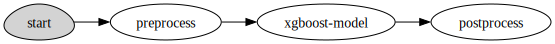

In [59]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Add the steps:
graph.to(handler="preprocess", name="preprocess") \
     .to("XGBModelServer",
         name="xgboost-model",
         model_path=xgb.model_data) \
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
serving_function.plot(rankdir='LR')

In [60]:
project.deploy_function("serving")

> 2024-02-07 17:13:49,933 [info] Starting remote function deploy
2024-02-07 17:13:50  (info) Deploying function
2024-02-07 17:13:50  (info) Building
2024-02-07 17:13:50  (info) Staging files and preparing base images
2024-02-07 17:13:50  (info) Building processor image
2024-02-07 17:15:36  (info) Build complete
Failed to deploy. Details:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/mlrun/serving/v2_serving.py", line 127, in _load_and_update_state
    self.load()
  File "/opt/nuclio/serving.py", line 21, in load
    model_file, extra_data = self.get_model(".tar.gz")
  File "/opt/conda/lib/python3.9/site-packages/mlrun/serving/v2_serving.py", line 197, in get_model
    model_file, self.model_spec, extra_dataitems = mlrun.artifacts.get_model(
  File "/opt/conda/lib/python3.9/site-packages/mlrun/artifacts/model.py", line 607, in get_model
    obj.download(temp_path)
  File "/opt/conda/lib/python3.9/site-packages/mlrun/datastore/base.py", line 473, in do

RunError: Function serving deployment failed

In [ ]:
samples = test_data.drop('transaction_category',axis=1)[:500].values.tolist()

In [ ]:
response = serving_function.invoke(path='/predict', body={"inputs": samples})

### 6. Evaluate performance <a class="anchor" id="Evaluate-performance"></a>

Run the model on our test data

In [ ]:
s3_data = "s3://{}/{}/test/test.csv".format(s3_bucket, bucket_prefix)

Add the evaluation function to our project

In [ ]:
evaluate_function = project.get_function("evaluate")

Run the evaluation job

In [ ]:
evaluate_run = evaluate_function.run(
    handler="evaluate",
    params={
        "model_path": xgb.model_data,
        "model_name": "xgboost-model",
        "test_set": s3_data,
        "label_column": "transaction_category",
        "factorize_key": factorize_key,
    },
    returns=["classification_report: dataset"])

See the evaluation result

In [ ]:
evaluate_run.artifact("classification_report").as_df()

You should see results similar to this:

```
                        precision    recall  f1-score   support

         Uncategorized       1.00      0.92      0.96        51
         Entertainment       0.81      0.89      0.85      1486
             Education       1.00      0.94      0.97        80
              Shopping       0.86      0.94      0.90      3441
         Personal Care       1.00      0.98      0.99       132
    Health and Fitness       0.99      0.89      0.94       443
       Food and Dining       0.99      0.82      0.90       918
   Gifts and Donations       1.00      0.95      0.97       275
           Investments       0.99      0.97      0.98        88
   Bills and Utilities       1.00      0.99      1.00       332
    Auto and Transport       0.94      0.84      0.88      1967
                Travel       0.96      0.84      0.90       120
      Fees and Charges       1.00      0.94      0.97       106
     Business Services       1.00      0.99      1.00       146
     Personal Services       1.00      0.96      0.98        75
                 Taxes       0.98      0.94      0.96        47
              Gambling       1.00      1.00      1.00        15
                  Home       0.98      0.89      0.93       168
Pension and insurances       0.99      1.00      1.00       110

              accuracy                           0.90     10000
             macro avg       0.97      0.93      0.95     10000
          weighted avg       0.91      0.90      0.90     10000
```

### 7. Clean up <a class="anchor" id="Clean-up"></a>

Remove the feature group and endpoint to clean up

In [ ]:
#feature_group.delete()
#xgb_predictor.delete_endpoint(delete_endpoint_config=True)

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/use-cases|financial_payment_classification|financial_payment_classification.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/use-cases|financial_payment_classification|financial_payment_classification.ipynb)
